In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


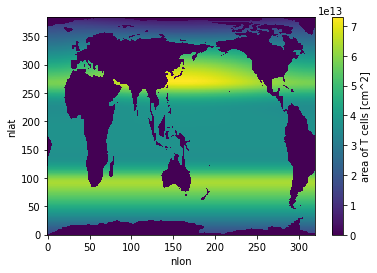

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area.plot()

In [4]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.16:44441 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
experiments = [
#    'piControl',
    'historical',
    'SSP1-2.6',
    'SSP2-4.5',
    'SSP3-7.0',
    'SSP5-8.5',
]

time_slice = {
    'historical': slice("1990-01-15", "2015-01-15"),
    'SSP1-2.6': slice("2086-01-15", "2101-01-15"),
    'SSP2-4.5': slice("2086-01-15", "2101-01-15"),
    'SSP3-7.0': slice("2086-01-15", "2101-01-15"),
    'SSP5-8.5': slice("2086-01-15", "2101-01-15"),
}

varlist = [
    'photoC_TOT_zint_100m',
    'photoC_diat_zint_100m',
    'photoC_diaz_zint_100m',
    'photoC_sp_zint_100m',
    'POC_FLUX_100m', 
]

In [6]:
nmolcm2s_to_molm2yr = 1e-9 * 1e4 * 86400 * 365.

dsets_epoch = {}
for experiment in experiments:

    if experiment == 'piControl': 
        continue
        
    ds_list = []
    for variable in varlist:
        xp_func = xp.persist_ds(cu.read_CESM_var, 
                                name=f'epoch-{experiment}-{variable}', 
                                trust_cache=True,)
        
       
        ds_list.append(
            xp_func(
                time_slice=time_slice[experiment], 
                variable=variable, 
                experiment=experiment,
                mean_dims=['member_id', 'time'],
            )
        )
    
    ds = xr.merge(ds_list)
    for v in varlist:
        assert ds[v].attrs['units'] == 'mmol/m^3 cm/s'
        assert ds[v].dims == ('nlat', 'nlon')
        
        ds[v] = ds[v] * nmolcm2s_to_molm2yr
        ds[v].attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'
    
    ds['NPP_diat_frac'] = ds.photoC_diat_zint_100m / ds.photoC_TOT_zint_100m
    ds['ep_ratio'] = ds.POC_FLUX_100m / ds.photoC_TOT_zint_100m
    dsets_epoch[experiment] = ds
    
dsets_epoch

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_TOT_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_diat_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_diaz_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_sp_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-POC_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP1-2.6-photoC_TOT_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d

{'historical': <xarray.Dataset>
 Dimensions:                (nlat: 384, nlon: 320, z_t: 60)
 Coordinates:
   * z_t                    (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
     TLONG                  (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
     TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
     ULONG                  (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
     ULAT                   (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
 Dimensions without coordinates: nlat, nlon
 Data variables:
     REGION_MASK            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     dz                     (z_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
     TAREA                  (nlat, nlon) float64 1.125e+13 ... 7.432e+12
     KMT                    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     photoC_TOT_zint_100m   (nlat, nlon) float32 nan nan nan nan ... nan nan nan
     photoC_diat_zint_100m  (nlat, nlon) floa

In [7]:
nmols_to_PgCyr = 1e-9 * 86400. * 365. * 12e-15

C_flux_vars = [
    'FG_CO2', 'photoC_TOT_zint_100m', 'photoC_diat_zint_100m', 'photoC_diaz_zint_100m',
    'photoC_sp_zint_100m', 'POC_FLUX_100m',
]

def global_ann_mean(ds, normalize=True):
    masked_area = ds.TAREA.where(ds.REGION_MASK > 0).fillna(0.)
    compute_vars = [
        v for v in ds 
        if 'time' in ds[v].dims and ('nlat', 'nlon') == ds[v].dims[-2:]
    ]
    
    nyr = int(len(ds.time) / 12)
    
    tb_name = ds.time.attrs['bounds']
    dim = ds[tb_name].dims[-1]
    ds['time'] = ds[tb_name].compute().mean(dim).squeeze()   
    
    weights = ds[tb_name].compute().diff(dim).squeeze()
    weights = weights.groupby('time.year') / weights.groupby('time.year').sum()
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyr))
    
    with xr.set_options(keep_attrs=True):
        
        dso = (ds[compute_vars] * masked_area).sum(['nlat', 'nlon'])    
        if normalize:
            dso = dso[compute_vars] / masked_area.sum(['nlat', 'nlon'])
        else:
            for v in compute_vars:
                if v in C_flux_vars:
                    dso[v] = dso[v] * nmols_to_PgCyr
                    dso[v].attrs['units'] = 'Pg C yr$^{-1}$'
                
        return (dso * weights).groupby('time.year').sum(dim='time')


In [8]:
pth = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'

dsets_ts = {}
for experiment in experiments:
    
    ds_list = []
    for variable in varlist:
        
        if os.path.exists(f'{pth}/transient-{experiment}-{variable}.nc'):
            os.remove(
                f'{pth}/transient-{experiment}-{variable}.nc'
            )
        
        xp_func = xp.persist_ds(cu.read_CESM_var, 
                                name=f'transient-{experiment}-{variable}', 
                                trust_cache=True,)
        
        normalize = variable not in C_flux_vars
        
        ds_list.append(
            xp_func(
                time_slice=None, 
                variable=variable, 
                postprocess=global_ann_mean,
                postprocess_kwargs=dict(normalize=normalize),
                experiment=experiment,
            )
        )

    ds = xr.merge(ds_list)
    ds['NPP_diat_frac'] = ds.photoC_diat_zint_100m / ds.photoC_TOT_zint_100m
    ds['ep_ratio'] = ds.POC_FLUX_100m / ds.photoC_TOT_zint_100m
    dsets_ts[experiment] = ds
    
dsets_ts


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-photoC_sp_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-historical-POC_FLUX_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP1-2.6-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP1-2.6-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP1-2.6-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP1-2.6-photoC_sp_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP1-2.6-POC_FLUX_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP2-4.5-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP2-4.5-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP2-4.5-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP2-4.5-photoC_sp_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP2-4.5-POC_FLUX_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP3-7.0-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP3-7.0-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP3-7.0-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP3-7.0-photoC_sp_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP3-7.0-POC_FLUX_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP5-8.5-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP5-8.5-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP5-8.5-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP5-8.5-photoC_sp_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-SSP5-8.5-POC_FLUX_100m.nc


{'historical': <xarray.Dataset>
 Dimensions:                (member_id: 11, year: 165)
 Coordinates:
   * member_id              (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
   * year                   (year) int64 1850 1851 1852 1853 ... 2012 2013 2014
 Data variables:
     photoC_TOT_zint_100m   (year, member_id) float64 47.31 48.64 ... 48.31 48.74
     photoC_diat_zint_100m  (year, member_id) float64 16.42 17.72 ... 16.85 18.24
     photoC_diaz_zint_100m  (year, member_id) float64 1.777 1.743 ... 1.795 1.829
     photoC_sp_zint_100m    (year, member_id) float64 29.11 29.17 ... 29.67 28.67
     POC_FLUX_100m          (year, member_id) float64 6.838 7.185 ... 6.929 7.125
     NPP_diat_frac          (year, member_id) float64 0.3471 0.3643 ... 0.3742
     ep_ratio               (year, member_id) float64 0.1445 0.1477 ... 0.1462,
 'SSP1-2.6': <xarray.Dataset>
 Dimensions:                (member_id: 3, year: 86)
 Coordinates:
   * member_id              (member_id) int64 4 10 11
   * year   

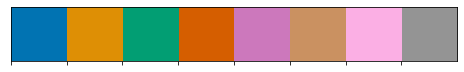

In [9]:
import seaborn as sns

current_palette = sns.color_palette('colorblind', 8)
sns.palplot(current_palette)

exp_colors = {
    'PI': current_palette.as_hex()[-1],
    'historical': 'k',
    'SSP1-2.6': current_palette.as_hex()[0],
    'SSP2-4.5': current_palette.as_hex()[1],
    'SSP3-7.0': current_palette.as_hex()[2],
    'SSP5-8.5': current_palette.as_hex()[3],
}

In [10]:
variable_labels = dict(
    year='Year',
    FG_CO2='Air-sea CO$_2$ flux [Pg C yr$^{-1}$]',
    photoC_TOT_zint_100m='NPP (z > -100m) [Pg C yr$^{-1}$]',
    photoC_TOT_zint='NPP [Pg C yr$^{-1}$]',
    POC_FLUX_100m='POC flux (100 m) [Pg C yr$^{-1}$]',
    ATM_CO2='Atmospheric CO$_2$ [ppm]',
    SST='Temperature [°C]',
    ep_ratio='ep ratio',
    NPP_diat_frac='Diatom fraction of NPP',
)

/glade/u/home/mclong/p/cesm2-marbl/notebooks/discrete_obs/tools.py:75: UserWarning: registration of accessor <class 'discrete_obs.tools.obs_datastream'> under name 'obs_stream' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor('obs_stream')


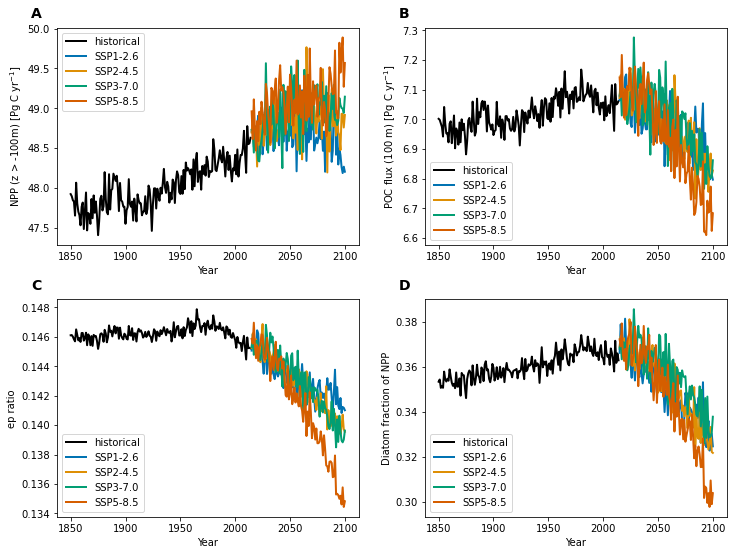

In [16]:
nrow = 2
ncol = 2
#fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), constrained_layout=False)

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    hspace=0.25,
    wspace=0.22,
)
axs = np.empty((2, 2)).astype(object)
for i, j in product(range(2), range(2)):
    axs[i, j] = plt.subplot(gs[i, j])


X = [['year', 'year'], ['year', 'year'],]
Y = [['photoC_TOT_zint_100m', 'POC_FLUX_100m'], ['ep_ratio', 'NPP_diat_frac'],]

for i, j in product(range(2), range(2)):
    ax = axs[i, j]
    x = X[i][j]
    y = Y[i][j]
    for exp in experiments:
        if exp == 'piControl':
            continue
        ds = dsets_ts[exp]
        #for member_id in ds.member_id.values:
        #    ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
        ax.plot(ds[x], ds[y].mean('member_id'), '-', linewidth=2, color=exp_colors[exp], label=exp)

    ax.set_ylabel(variable_labels[y])    
    ax.legend()
    ax.set_xlabel(variable_labels[x])
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.03, yoff=0.015)   

utils.savefig(f'global-timeseries-bio-pump.pdf')

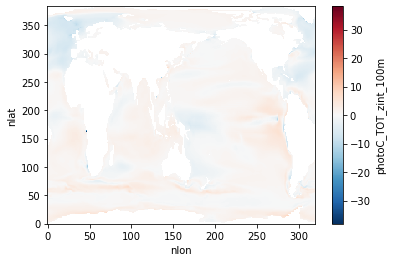

In [12]:
dsets_delta = dsets_epoch['SSP5-8.5'] - dsets_epoch['historical']
dsets_delta.photoC_TOT_zint_100m.plot()

In [13]:
dsp = utils.pop_add_cyclic(dsets_delta)
dsp

<xarray.Dataset>
Dimensions:                (nlat: 384, nlon: 321, z_t: 60)
Coordinates:
  * z_t                    (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                  (nlat, nlon) float64 -220.6 -219.4 ... -39.57 -39.86
    REGION_MASK            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dz                     (z_t) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TAREA                  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    KMT                    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                     ...
    photoC_diat_zint_100m  (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    photoC_diaz_zint_100m  (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    photoC_sp_zint_100m    (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    POC_FLUX_100m          (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    NPP_diat_frac          (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    ep_ratio               (nlat, nlon) float32 nan nan nan nan ... nan nan nan

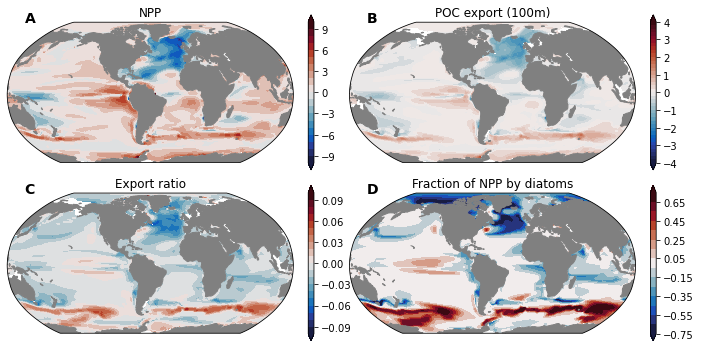

In [14]:
fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

titles = dict(
    photoC_TOT_zint_100m='NPP', 
    POC_FLUX_100m='POC export (100m)', 
    ep_ratio='Export ratio',
    NPP_diat_frac='Fraction of NPP by diatoms',
)


nrow, ncol = 2, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol*3, 
    width_ratios=(1, 0.02, 0.02)*ncol,
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j*3], projection=prj)
    caxs[i, j] = plt.subplot(gs[i, j*3+1])

    
levels = dict(
    photoC_TOT_zint_100m=np.arange(-10, 11, 1),
    POC_FLUX_100m=np.arange(-4, 4.2, 0.2),
    ep_ratio=np.arange(-0.1, 0.101, 0.01),
    NPP_diat_frac=np.arange(-0.75, 0.76, 0.1)
)

cmap_field = cmocean.cm.balance

for n, field in enumerate(['photoC_TOT_zint_100m', 'POC_FLUX_100m', 'ep_ratio', 'NPP_diat_frac']):
    
    i, j = np.unravel_index(n, axs.shape)
    
    ax = axs[i, j]
   
    cf = ax.contourf(
        dsp.TLONG,dsp.TLAT, dsp[field],
        levels=levels[field],
        extend='both',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )  
                             
    ax.set_title(titles[field]) #dsp[field].attrs['title_str'])

    
    cb = plt.colorbar(cf, cax=caxs[i, j])
    if 'units' in dsp[field].attrs:
        cb.ax.set_title(dsp[field].attrs['units'])
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('bio-pump-change-2100-SSP5-8.5.pdf')

In [15]:
del client
del cluster